In [32]:
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma,gamma_natural
from exojax.spec.exomol import gamma_exomol
from exojax.spec import moldb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from exojax.spec import dit
from exojax.spec import lpf
plt.style.use('bmh')

In [6]:
# Setting wavenumber bins and loading ExoMol database
nus=np.linspace(1900.0,2300.0,80000,dtype=np.float64) 
emf='CO/12C-16O/Li2015'
mdbCO=moldb.MdbExomol(emf,nus)

Background atmosphere:  H2
Error: Couldn't download .broad file and save.
Note: Couldn't find the feather format. We convert data to the feather format. After the second time, it will become much faster.
Reading transition file
Note: Couldn't find the feather format. We convert data to the feather format. After the second time, it will become much faster.
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states


In [8]:
Mmol=28.010446441149536 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere.
qt=mdbCO.qr_interp(Tfix)

In [13]:
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_exomol(Pfix,Tfix,mdbCO.n_Texp,mdbCO.alpha_ref)\
+ gamma_natural(mdbCO.A)
# thermal doppler sigma
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

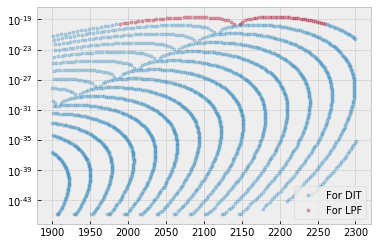

In [24]:
mask=Sij<0.1*np.max(Sij)
#plt.plot(mdbCO.nu_lines,Sij,".")
plt.plot(mdbCO.nu_lines[mask],Sij[mask],".",alpha=0.3,label="For DIT")
plt.plot(mdbCO.nu_lines[~mask],Sij[~mask],".",alpha=0.3,label="For LPF")
plt.legend()
plt.yscale("log")

In [67]:
print("# for DIT=",len(Sij[mask]),", # for LPF=",len(Sij[~mask]))

# for DIT= 3577 , # for LPF= 72


Checking the range of doppler and Lorentz widths

In [25]:
sigmaD_grid=set_ditgrid(sigmaD[mask])
gammaL_grid=set_ditgrid(gammaL[mask])

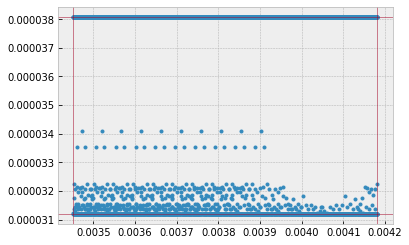

In [26]:
plt.plot(sigmaD,gammaL,".")
for i in sigmaD_grid:
    plt.axvline(i,lw=1,alpha=0.5,color="C1")
for i in gammaL_grid:
    plt.axhline(i,lw=1,alpha=0.5,color="C1")

In [ ]:
# computing DIT+LPF

In [43]:
xsdit=dit.xsvector(mdbCO.nu_lines[mask],sigmaD[mask],gammaL[mask],Sij[mask]\
                   ,nus,sigmaD_grid,gammaL_grid)

In [44]:
from exojax.spec import make_numatrix0
numatrix=make_numatrix0(nus,mdbCO.nu_lines[~mask])
xslpf=lpf.xsvector(numatrix,sigmaD[~mask],gammaL[~mask],Sij[~mask])

In [45]:
xshybrid=xsdit+xslpf

In [ ]:
# for comparison, we compute xs only using LPF 

In [31]:
xslpfall=xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30) 

100%|██████████| 38/38 [00:01<00:00,  5.28it/s]


Text(0, 0.5, 'Difference (cm2)')

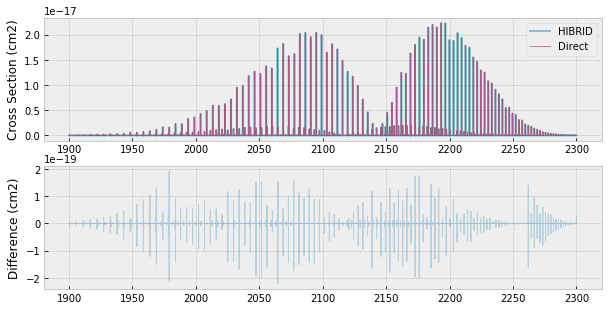

In [51]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xshybrid,lw=2,alpha=0.5,label="HIBRID")
plt.plot(nus,xslpfall,lw=1,alpha=0.5,label="Direct")
plt.legend()
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xshybrid-xslpfall,lw=1,alpha=0.3)
plt.ylabel("Difference (cm2)")

Text(0, 0.5, 'Difference (cm2)')

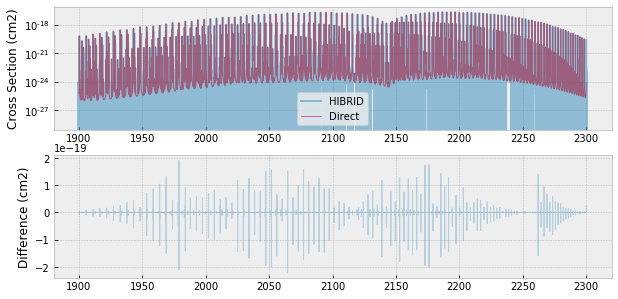

In [53]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xshybrid,lw=2,alpha=0.5,label="HIBRID")
plt.plot(nus,xslpfall,lw=1,alpha=0.5,label="Direct")
plt.legend()
plt.yscale("log")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xshybrid-xslpfall,lw=1,alpha=0.3)
plt.ylabel("Difference (cm2)")

(2000, 2150)

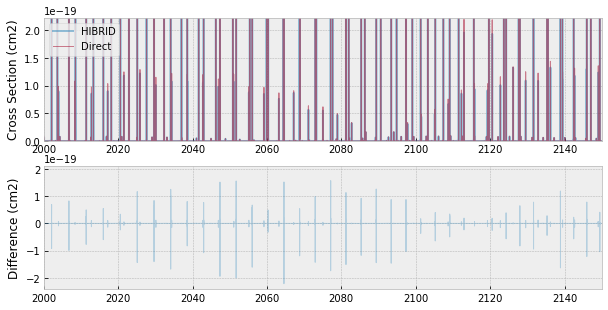

In [62]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xshybrid,lw=2,alpha=0.5,label="HIBRID")
plt.plot(nus,xslpfall,lw=1,alpha=0.5,label="Direct")
plt.ylim(0,0.01*np.max(xslpfall))
plt.legend()
plt.xlim(2000,2150)
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xshybrid-xslpfall,lw=1,alpha=0.3)
plt.ylabel("Difference (cm2)")
plt.xlim(2000,2150)